# Classify eQTL vs negative control variants

In [1]:
import numpy as np
import pandas as pd
import os
import scipy
from tqdm import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

In [2]:
def compute_ap_with_bootstrap(y_true: np.ndarray, y_scores: np.ndarray, n_bootstraps: int = 100, 
                              confidence_level: float = 0.95):
    """
    Computes the Average Precision and its bootstrapped confidence interval.

    Args:
        y_true (np.ndarray): True binary labels (0 or 1).
        y_scores (np.ndarray): Target scores, can either be probability estimates of the positive class,
                                confidence values, or non-thresholded decision values.
        n_bootstraps (int): Number of bootstrap samples to draw. Defaults to 1000.
        confidence_level (float): The desired confidence level for the interval (e.g., 0.95 for 95%).
                                  Defaults to 0.95.

    Returns:
        tuple: A tuple containing:
            - auprc (float): The single AP score computed on the full dataset.
            - lower_bound (float): The lower bound of the confidence interval.
            - upper_bound (float): The upper bound of the confidence interval.
            - auprc_scores (list): A list of AP scores from each bootstrap sample.
    """

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Check for valid input dimensions
    if y_true.shape != y_scores.shape:
        print("Error: y_true and y_scores must have the same shape.")
        return None, None, None, None
    if y_true.ndim > 1 or y_scores.ndim > 1:
        print("Error: y_true and y_scores must be 1-dimensional arrays.")
        return None, None, None, None
    if not np.isin(y_true, [0, 1]).all():
        print("Error: y_true must contain only 0s and 1s.")
        return None, None, None, None

    # Compute AUPRC on the original dataset
    auprc = average_precision_score(y_true, y_scores)

    # Store AUPRC scores from bootstrap samples
    auprc_scores = []
    n_samples = len(y_true)

    for i in range(n_bootstraps):
        # Sample with replacement (bootstrapping)
        # We sample indices to keep y_true and y_scores aligned
        indices = np.random.choice(n_samples, n_samples, replace=True)
        boot_y_true = y_true[indices]
        boot_y_scores = y_scores[indices]

        # Handle cases where a bootstrap sample might have only one class
        # (which breaks average_precision_score)
        if len(np.unique(boot_y_true)) < 2:
            continue # Skip this sample if it doesn't have both classes

        try:
            boot_auprc = average_precision_score(boot_y_true, boot_y_scores)
            auprc_scores.append(boot_auprc)
        except Exception as e:
            continue

    # Convert to numpy array for percentile calculation
    auprc_scores = np.array(auprc_scores)

    if len(auprc_scores) == 0:
        print("Error: No valid AUPRC scores could be computed from bootstrap samples.")
        return auprc, np.nan, np.nan, []

    # Calculate confidence interval
    alpha = 1.0 - confidence_level
    lower_percentile = alpha / 2.0 * 100
    upper_percentile = (1.0 - alpha / 2.0) * 100

    lower_bound = np.percentile(auprc_scores, lower_percentile)
    upper_bound = np.percentile(auprc_scores, upper_percentile)

    return auprc, lower_bound, upper_bound

# Paths

In [3]:
eqtl_file = 'scored_sceqtls.csv'

## Load data

In [4]:
eqtl_df = pd.read_csv(eqtl_file)

## Subset to common genes

In [5]:
positive_genes = eqtl_df[eqtl_df.label].gene_id
negative_genes = eqtl_df[~eqtl_df.label].gene_id
sel_genes = set(positive_genes).intersection(negative_genes)

eqtl_df = eqtl_df[eqtl_df.gene_id.isin(sel_genes)]

print(len(eqtl_df), eqtl_df['label'].sum(), (~eqtl_df['label']).sum())

27332 984 26348


## Subset 20 negatives per positive

In [6]:
pos_sel = eqtl_df[eqtl_df.label]
neg_sel = []
for row in pos_sel.itertuples():
    curr_neg = eqtl_df[(~eqtl_df.label) & (eqtl_df.gene_id==row.gene_id) & (eqtl_df.celltype==row.celltype)]
    curr_neg = curr_neg.sort_values('abspos_rel_TSS').head(20)
    neg_sel.append(curr_neg)

neg_sel = pd.concat(neg_sel)
eqtl_df = pd.concat([pos_sel, neg_sel]).reset_index(drop=True)
print(len(eqtl_df), eqtl_df['label'].sum(), (~eqtl_df['label']).sum())

20615 984 19631


## Compute overall AUPRC

In [7]:
decima_ap = compute_ap_with_bootstrap(eqtl_df.label, eqtl_df['abs_matched_score'])
borzoi_blood_ap = compute_ap_with_bootstrap(eqtl_df.label, eqtl_df['abs_borzoi_wholeblood_score'])
borzoi_ap = compute_ap_with_bootstrap(eqtl_df.label, eqtl_df['abs_borzoi_matched_score'])
distance_ap = compute_ap_with_bootstrap(eqtl_df.label, -eqtl_df['abspos_rel_TSS'])

In [8]:
for ap in [decima_ap, borzoi_blood_ap, borzoi_ap, distance_ap]:
    print(f"AP: {ap[0]:.2f} Lower: {ap[1]:.2f} Upper: {ap[2]:.2f}")

AP: 0.39 Lower: 0.35 Upper: 0.43
AP: 0.29 Lower: 0.26 Upper: 0.32
AP: 0.32 Lower: 0.28 Upper: 0.36
AP: 0.12 Lower: 0.10 Upper: 0.14


In [9]:
p_decima, r_decima, _ = precision_recall_curve(eqtl_df.label, eqtl_df['abs_matched_score'])
p_borzoi_blood, r_borzoi_blood, _ = precision_recall_curve(eqtl_df.label, eqtl_df['abs_borzoi_wholeblood_score'])
p_borzoi, r_borzoi, _ = precision_recall_curve(eqtl_df.label, eqtl_df['abs_borzoi_matched_score'])
p_dist, r_dist, _ = precision_recall_curve(eqtl_df.label, -eqtl_df['abspos_rel_TSS'])

In [10]:
rows = []

for celltype in set(eqtl_df.celltype):

    # Get eQTLs and negatives for this cell type
    sub = eqtl_df[eqtl_df.celltype == celltype].copy()
    positive_genes = sub[sub.label].gene_id
    negative_genes = sub[~sub.label].gene_id
    sub = sub[sub.gene_id.isin(set(positive_genes).intersection(negative_genes))]

    # Count positives and negatives
    labels = sub.label
    positives = labels.sum()
    negatives = (~labels).sum()
    if positives == 0 or negatives == 0:
        continue

    # Compute AP
    decima_ap = compute_ap_with_bootstrap(labels, sub['abs_matched_score'], n_bootstraps=100)
    borzoi_blood_ap = average_precision_score(labels, sub['abs_borzoi_wholeblood_score'])
    borzoi_ap = compute_ap_with_bootstrap(labels, sub['abs_borzoi_matched_score'], n_bootstraps=100)
    distance_ap = average_precision_score(labels, -sub['abspos_rel_TSS'])
    rows.append({'celltype':celltype,
        'decima_ap':decima_ap[0], 'decima_lower':decima_ap[1], 'decima_upper':decima_ap[2],
        'borzoi_ap':borzoi_ap[0], 'borzoi_lower':borzoi_ap[1], 'borzoi_upper':borzoi_ap[2],
        'borzoi_blood_ap':borzoi_blood_ap, 'distance_ap':distance_ap,
        'positives':positives, 'negatives':negatives,
    })

metrics = pd.DataFrame(rows)
metrics.head()

,celltype,decima_ap,decima_lower,decima_upper,borzoi_ap,borzoi_lower,borzoi_upper,borzoi_blood_ap,distance_ap,positives,negatives
0,CD56+ NK cell,1.000000,1.000000,1.000000,0.861111,0.513333,1.000000,1.000000,0.507784,4,80
1,CD4+ TEM cell,0.561222,0.319178,0.804818,0.327748,0.156426,0.605033,0.337059,0.240214,16,320
2,CD4+ TCM cell,0.420940,0.371414,0.488474,0.402641,0.342608,0.457979,0.347539,0.159345,284,5668
3,CD4+ CTL cell,0.637033,0.211147,0.975227,0.555251,0.153192,0.859716,0.398036,0.277701,6,120
4,plasmablast,0.866667,0.265179,1.000000,0.805556,0.360417,1.000000,0.666667,0.270408,3,60


## Plot Decima performance

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 3 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: decima_ct_auprc.svg


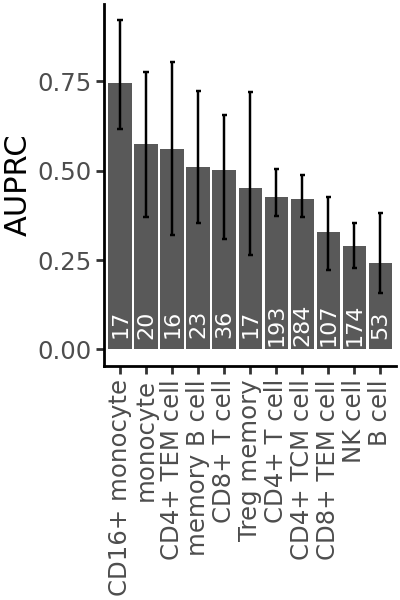

In [11]:
metrics.celltype = pd.Categorical(metrics.celltype, categories = metrics.sort_values('decima_ap', ascending=False).celltype.tolist())
p = (
    ggplot(metrics[metrics.positives > 10], aes(x='celltype', y='decima_ap')) 
    + geom_col()
    + theme_classic()
    + theme(figure_size=(2, 3)) 
    + theme(axis_text_x=element_text(rotation=90, hjust=.5))
    + xlab("") + ylab("AUPRC")
    + geom_errorbar(aes(ymin='decima_lower', ymax='decima_upper'), width=0.2)
    + geom_text(aes(label='positives', y=0.07), size=8, color='white', angle=90)
)
p.save('decima_ct_auprc.svg')
p

## Compare to baseline

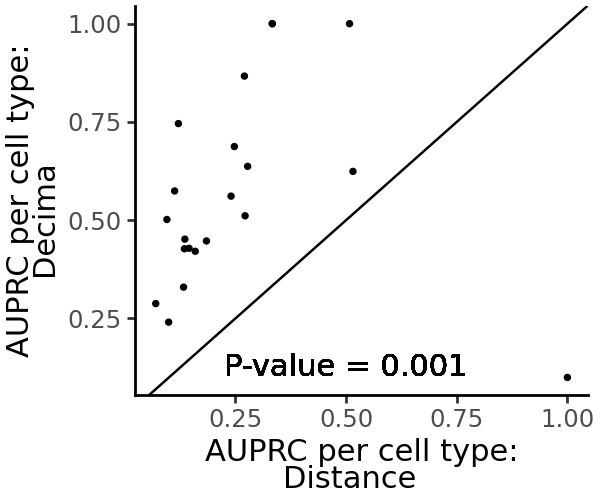

In [12]:
pval = scipy.stats.wilcoxon(metrics['decima_ap'],metrics['distance_ap'])[1]
(
    ggplot(metrics, aes(x='distance_ap', y = 'decima_ap')) +\
    geom_point(size=.5) + theme_classic() + theme(figure_size=(3,2.5)) + geom_abline(intercept=0, slope=1) 
    + xlab("AUPRC per cell type:\n        Distance") + ylab("AUPRC per cell type:\n        Decima")
    + geom_text(x=0.5, y=0.125, label=f"P-value = {np.round(pval, 4)}") 
)

## Compare to Borzoi

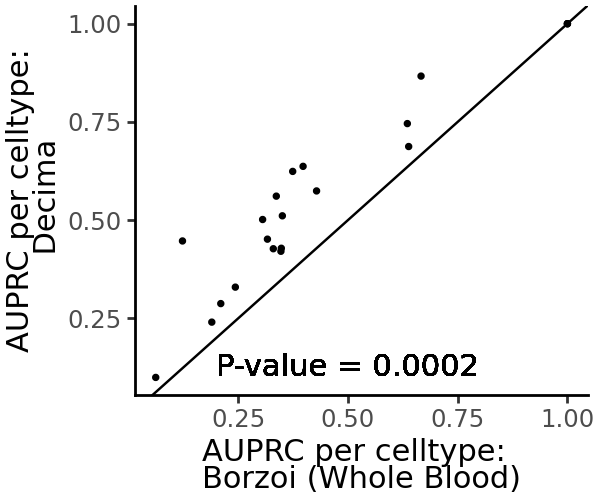

In [13]:
pval = scipy.stats.wilcoxon(metrics['decima_ap'], metrics['borzoi_blood_ap'])[1]
(
    ggplot(metrics, aes(x='borzoi_blood_ap', y = 'decima_ap')) + geom_point(size=.5) 
    + theme_classic() + theme(figure_size=(3, 2.5)) + geom_abline(intercept=0, slope=1) 
    + xlab("AUPRC per celltype:\nBorzoi (Whole Blood)") + ylab("AUPRC per celltype:\n          Decima ")
    + geom_text(x=0.5, y=0.125, label=f"P-value = {np.round(pval, 4)}") 
)

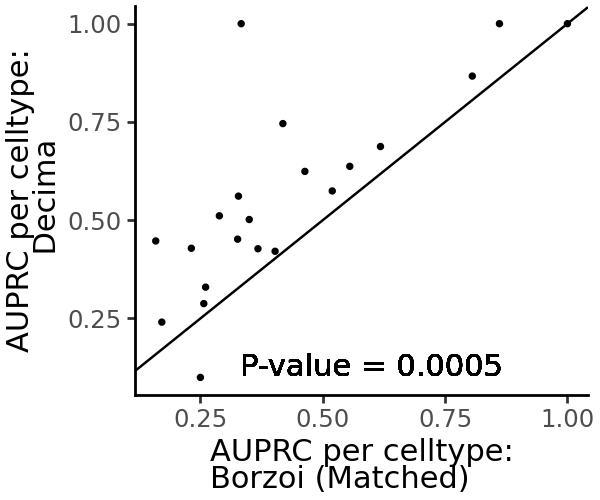

In [14]:
pval = scipy.stats.wilcoxon(metrics['decima_ap'], metrics['borzoi_ap'])[1]
(
    ggplot(metrics, aes(x='borzoi_ap', y = 'decima_ap')) + geom_point(size=.5) 
    + theme_classic() + theme(figure_size=(3, 2.5)) + geom_abline(intercept=0, slope=1) 
    + xlab("AUPRC per celltype:\nBorzoi (Matched)") + ylab("AUPRC per celltype:\n          Decima ")
    + geom_text(x=0.6, y=0.125, label=f"P-value = {np.round(pval, 4)}") 
)